In [1]:
from ztfquery import query
import pyvo as vo

import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.stats import sigma_clipped_stats
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS

import matplotlib.font_manager as font_manager
from matplotlib.ticker import MultipleLocator

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as pat
import matplotlib.image as mpimg

from scipy.ndimage import gaussian_filter

from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAnnulus


import os

from scipy.stats import chi2
from scipy.special import erf

from tools import phot_tools as phot

from tools import plotting_tools as pt
import astropy.units as u
import pandas as pd

from numpy.random import normal

In [25]:
## This function performs the aperature photometry and returns instrumental magnitudes for a given source
##  at (_ra, _dec)

## The cal_ra, cal_dec option is so that you do not have to repull all the images for both the desired
##  source and the calibrators. To get the photometry for the calibrator star, input the ra and dec for
##  the desired agn first at _ra, _dec and then also the calirator ra and dec at cal_ra, cal_dec


def calibrator_calc(_ra, _dec, urls, cal_ra = False, cal_dec = False):
    """
    Input _ra and _dec as well as a list of APIs for a desired source (AGN)
    and performs photometry.
    
    Input _ra and dec for a desired source (AGN)
    and also cal_ra and cal_dec for a given calibrator
    source and return calibrator photometry.
    
    args:   _ra: right ascension in degrees for the desired source
            _dec: declination in degrees for the desired source
            urls: takes a list of the ZTF API urls from which to pull the images necessary to do the photometry
            cal_ra: right ascension in degrees for the calibrator star
                    (leave false for instrumental photometry of desired source)
            cal_dec: declination in degrees for the calibrator star
                    (leave false for instrumental photometry of desired source)
    
    returns:    
            inst_mags: instrumental magnitude for either the input source at given
                       _ra, _dec or cal_ra,cal_dec
            epochs: the dates at which the observations where taken
            
        


    """    
    inst_mags = []
    epochs = [] 
    inst_mag_errs = [] 
    epoch_mjds = [] 
    xs = [] 
    ys = [] 
    final_counts = [] 
    ap_errs = []
    
    cal_inst_mags = []
    cal_epochs = [] 
    cal_inst_mag_errs = [] 
    cal_epoch_mjds = [] 
    cal_xs = [] 
    cal_ys = [] 
    cal_final_counts = [] 
    cal_ap_errs = []
    
    
    for i in range(len(urls)):
    
        try:
            exp1 = fits.open(urls[i])
            print(i+1,'/',len(urls))
        except:
            continue
    
        exp1_data = exp1[0].data
    
        w = wcs.WCS(exp1[0].header)
    
        sky = SkyCoord(ra = _ra,dec = _dec, frame = "icrs", unit = "deg")#, equinox = 'J2000')
    
        x,y = w.world_to_pixel(sky)
        
    
        ## Requiring the science image to include a 13 pixel buffer around the source
        
    
        if x+13 > np.shape(exp1_data)[1] or x-13 < 0 or y+13 > np.shape(exp1_data)[0] or y-13 < 0:
            inst_mags.append(np.nan)
            epochs.append(np.nan)
            inst_mag_errs.append(np.nan)
            epoch_mjds.append(np.nan)
            xs.append(np.nan) 
            ys.append(np.nan)
            final_counts.append(np.nan) 
            ap_errs.append(np.nan)
            
            continue
            
            #return(np.nan,np.nan,np.nan,np.nan, np.nan, np.nan, np.nan, np.nan)
    
        if np.isnan(x) or np.isnan(y):
            inst_mags.append(np.nan)
            epochs.append(np.nan)
            inst_mag_errs.append(np.nan)
            epoch_mjds.append(np.nan)
            xs.append(np.nan) 
            ys.append(np.nan)
            final_counts.append(np.nan) 
            ap_errs.append(np.nan)
            
            continue
    
        if exp1[0].header['SEEING'] > 3:
            inst_mags.append(np.nan)
            epochs.append(np.nan)
            inst_mag_errs.append(np.nan)
            epoch_mjds.append(np.nan)
            xs.append(np.nan) 
            ys.append(np.nan)
            final_counts.append(np.nan) 
            ap_errs.append(np.nan)
            
            continue
    
        ## Minimizing the S/N for the aperture by adjusting for seeing
    
        ap_radius = exp1[0].header['SEEING'] * 1.4 / 2
    
        #print(x,y)
    
        if ap_radius >= 2:
            aperture = CircularAperture((x,y), r=ap_radius)
        else:
            aperture = CircularAperture((x,y), r=2)
    
        bkg_annulus = CircularAnnulus((x,y), r_in=8, r_out=12)
    
        apers = [aperture,bkg_annulus]
    
        phot_table = aperture_photometry(exp1_data, apers, method = 'exact')
    
        ## Computing variance within source aperture for error 
    
        ap_mask = aperture.to_mask(method = 'center')
    
        ap_data = ap_mask.multiply(exp1_data)
    
        mask = ap_mask.data
    
        ap_data_1d = ap_data[mask > 0]
    
    
        ## Background subtracting
    
        bkg_mask = bkg_annulus.to_mask(method = 'center')
    
        bkg_data = bkg_mask.multiply(exp1_data)
    
        mask = bkg_mask.data
    
        bkg_data_1d = bkg_data[mask > 0]
    
        mean_sigclip, median_sigclip, std_sigclip = sigma_clipped_stats(bkg_data_1d, sigma = 2)
    
        ap_variance = std_sigclip
    
        ap_err = ap_variance * np.sqrt(aperture.area)
    
        #print(bkg_data_1d)
    
    
    
        bkg_sum = median_sigclip * aperture.area
    
    
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
    
    
        # Deriving instrumental magnitude from final counts
    
        final_count = final_sum.data[0]
    
        inst_mag = -2.5*np.log10(final_count)
    
        inst_mag_err = 2.5*np.log10(final_count + ap_err) + inst_mag
    
        epoch_mjd = exp1[0].header['OBSMJD']
        #print(epoch_mjd)
        
        
        t = Time(epoch_mjd, format = 'mjd')
    
        epoch = t.byear
        
        
        inst_mags.append(inst_mag)
        epochs.append(epoch)
        inst_mag_errs.append(inst_mag_err)
        epoch_mjds.append(epoch_mjd)
        xs.append(x) 
        ys.append(y)
        final_counts.append(final_count) 
        ap_errs.append(ap_err)
            
        
        ##########################################
            
        
    
        
    
        sky = SkyCoord(ra = cal_ra,dec = cal_dec, frame = "icrs", unit = "deg")#, equinox = 'J2000')
    
        x,y = w.world_to_pixel(sky)
        
        x = x[0]
        y = y[0]
        
        ## Requiring the science image to include a 13 pixel buffer around the source
        
    
        if x+13 > np.shape(exp1_data)[1] or x-13 < 0 or y+13 > np.shape(exp1_data)[0] or y-13 < 0:
            inst_mags.append(np.nan)
            epochs.append(np.nan)
            inst_mag_errs.append(np.nan)
            epoch_mjds.append(np.nan)
            xs.append(np.nan) 
            ys.append(np.nan)
            final_counts.append(np.nan) 
            ap_errs.append(np.nan)
        
            continue
        
            #return(np.nan,np.nan,np.nan,np.nan, np.nan, np.nan, np.nan, np.nan)
    
        if np.isnan(x) or np.isnan(y):
            inst_mags.append(np.nan)
            epochs.append(np.nan)
            inst_mag_errs.append(np.nan)
            epoch_mjds.append(np.nan)
            xs.append(np.nan) 
            ys.append(np.nan)
            final_counts.append(np.nan) 
            ap_errs.append(np.nan)
        
            continue
    
        if exp1[0].header['SEEING'] > 3:
            inst_mags.append(np.nan)
            epochs.append(np.nan)
            inst_mag_errs.append(np.nan)
            epoch_mjds.append(np.nan)
            xs.append(np.nan) 
            ys.append(np.nan)
            final_counts.append(np.nan) 
            ap_errs.append(np.nan)
        
            continue
    
        ## Minimizing the S/N for the aperture by adjusting for seeing
    
        if ap_radius >= 2:
            aperture2 = CircularAperture((x,y), r=ap_radius)
        else:
            aperture2 = CircularAperture((x,y), r=2)
    
    
    
    
        bkg_annulus = CircularAnnulus((x,y), r_in=8, r_out=12)
    
        apers = [aperture2,bkg_annulus]
    
        phot_table = aperture_photometry(exp1_data, apers, method = 'exact')
    
        ## Computing variance within source aperture for error 
    
        ap_mask = aperture.to_mask(method = 'center')
    
        ap_data = ap_mask.multiply(exp1_data)
    
        mask = ap_mask.data
    
        ap_data_1d = ap_data[mask > 0]
    
    
        ## Background subtracting
    
        bkg_mask = bkg_annulus.to_mask(method = 'center')
    
        bkg_data = bkg_mask.multiply(exp1_data)
    
        mask = bkg_mask.data
    
        bkg_data_1d = bkg_data[mask > 0]
    
        mean_sigclip, median_sigclip, std_sigclip = sigma_clipped_stats(bkg_data_1d, sigma = 2)
    
        ap_variance = std_sigclip
    
        ap_err = ap_variance * np.sqrt(aperture.area)
            
    
        bkg_sum = median_sigclip * aperture.area
    
    
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
    
    
        # Deriving instrumental magnitude from final counts
    
        final_count = final_sum.data[0]
        exp_time = exp1[0].header['EXPOSURE']
    
        inst_mag = -2.5*np.log10(final_count)
    
        inst_mag_err = 2.5*np.log10(final_count + ap_err) + inst_mag
    
        
        cal_inst_mags.append(inst_mag)
        cal_epochs.append(epoch)
        cal_inst_mag_errs.append(inst_mag_err)
        cal_epoch_mjds.append(epoch_mjd)
        cal_xs.append(x) 
        cal_ys.append(y)
        cal_final_counts.append(final_count) 
        cal_ap_errs.append(ap_err)
        

    sorting = np.argsort(epoch_mjds)


    inst_mags = np.array(inst_mags)[sorting]
    epochs = np.array(epochs)[sorting]
    inst_mag_errs = np.array(inst_mag_errs)[sorting]
    epoch_mjds = np.array(epoch_mjds)[sorting]
    xs = np.array(xs)[sorting]
    ys = np.array(ys)[sorting]
    final_counts = np.array(final_counts)[sorting]
    ap_errs = np.array(ap_errs)[sorting]    

    sorting = np.argsort(cal_epoch_mjds)

        
    cal_inst_mags = np.array(cal_inst_mags)[sorting]
    cal_epochs = np.array(cal_epochs)[sorting]
    cal_inst_mag_errs = np.array(cal_inst_mag_errs)[sorting]
    cal_epoch_mjds = np.array(cal_epoch_mjds)[sorting]
    cal_xs = np.array(cal_xs)[sorting]
    cal_ys = np.array(cal_ys)[sorting]
    cal_final_counts = np.array(cal_final_counts)[sorting]
    cal_ap_errs = np.array(cal_ap_errs)[sorting]
        
    exp1.close()
        
    del exp1_data
    del exp1
    
    return(inst_mags, epochs, inst_mag_errs, epoch_mjds, xs, ys, final_counts, ap_errs, cal_inst_mags, cal_epochs, cal_inst_mag_errs, cal_epoch_mjds, cal_xs, cal_ys, cal_final_counts, cal_ap_errs)



def data_maker(ra, dec, cal_ra, cal_dec, pan_mag, pan_mag_err):
    
    
    zquery = query.ZTFQuery()

    zquery.load_metadata(radec=[ra, dec], sql_query="filtercode = 'zr' AND infobits < 10")
    
    urls = zquery.get_data_path(suffix='sciimg.fits')
    
    agn_nan_counter = []

    mags, epochs, errs, mjds, xs, ys, fluxes, flux_errs, cal_mags, cal_epochs, cal_errs, cal_mjds, cal_xs, cal_ys, cal_fluxes, cal_flux_errs = calibrator_calc(ra, dec, urls, cal_ra = cal_ra, cal_dec = cal_dec)
    
    for i in range(len(mags)):
        if np.isnan(mags[i]):
            agn_nan_counter.append(i)
    
    final_mags = np.array([x for x in mags if np.isnan(x) == False])

    i1 = np.where(np.isnan(mags))

    final_epochs = np.delete(epochs, i1)

    final_mag_err = np.delete(errs, i1)

    final_epoch_mjd = np.delete(mjds, i1)

    xs = np.delete(xs, i1)
    
    ys = np.delete(ys, i1)
    
    final_flux_errs = np.delete(flux_errs, i1)
    final_fluxes = np.delete(fluxes, i1)
    
    cal_nan_counter = []

    for i in range(len(cal_mags)):
        if np.isnan(cal_mags[i]):
            cal_nan_counter.append(i)

    
    deleted_epochs = False
    
    if len([x for x in cal_nan_counter if x not in agn_nan_counter]) > 20:
        deleted_epochs = True
    
    cal_final_mags = np.array([x for x in cal_mags if np.isnan(x) == False])

    i1 = np.where(np.isnan(cal_mags))

    cal_final_epochs = np.delete(cal_epochs, i1)

    cal_final_mag_err = np.delete(cal_errs, i1)

    cal_final_epoch_mjd = np.delete(cal_mjds, i1)

    cal_xs = np.delete(cal_xs, i1)
    
    cal_ys = np.delete(cal_ys, i1)
    
    #print(len(cal_final_mags))
    #print(len(final_mags))
    
    #print(final_mags)
    
    
    #print(cal_final_mags)
    
    zeropts = pan_mag - cal_final_mags
    zpt_err = np.hypot(cal_final_mag_err, pan_mag_err)
    
    combined_epochs = []
    mag_diff = []
    combined_err = []
    
    combined_fluxes = []
    combined_flux_errs = []
    

    for i in range(len(final_epoch_mjd)):
        for j in range(len(cal_final_epoch_mjd)):
            if final_epoch_mjd[i] == cal_final_epoch_mjd[j]:
                combined_epochs.append(cal_final_epoch_mjd[j])

                mag_diff.append(zeropts[j] + final_mags[i])

                combined_err.append(np.hypot(final_mag_err[i], zpt_err[j]))
                
                combined_fluxes.append(final_fluxes[i])
                combined_flux_errs.append(final_flux_errs[i])

                
    #print([x for x in final_epoch_mjd if x not in combined_epochs])
    
    combined_epochs = np.array(combined_epochs)
    mag_diff = np.array(mag_diff)
    combined_err = np.array(combined_err)
    combined_fluxes = np.array(combined_fluxes)
    combined_flux_errs = np.array(combined_flux_errs)
    
    print(mag_diff)
    #print('Calibration Success!')
    return(mag_diff, combined_err, combined_epochs, combined_fluxes, combined_flux_errs, deleted_epochs)
    
    
def photo_pts(_ra, _dec, urls):

    inst_mags = []
    epochs = [] 
    inst_mag_errs = [] 
    epoch_mjds = [] 
    xs = [] 
    ys = [] 
    final_counts = [] 
    ap_errs = []

    for i in range(len(urls)):

        try:
            exp1 = fits.open(urls[i])
            print('opened')
        except:
            continue
    
        exp1_data = exp1[0].data

        w = wcs.WCS(exp1[0].header)

        sky = SkyCoord(ra = _ra,dec = _dec, frame = "icrs", unit = "deg")#, equinox = 'J2000')

        x,y = w.world_to_pixel(sky)

        ## Requiring the science image to include a 13 pixel buffer around the source

        if x+13 > np.shape(exp1_data)[1] or x-13 < 0 or y+13 > np.shape(exp1_data)[0] or y-13 < 0:
            inst_mags.append(np.nan)
            epochs.append(np.nan)
            inst_mag_errs.append(np.nan)
            epoch_mjds.append(np.nan)
            xs.append(np.nan) 
            ys.append(np.nan)
            final_counts.append(np.nan) 
            ap_errs.append(np.nan)
            
            continue

        if np.isnan(x) or np.isnan(y):
            inst_mags.append(np.nan)
            epochs.append(np.nan)
            inst_mag_errs.append(np.nan)
            epoch_mjds.append(np.nan)
            xs.append(np.nan) 
            ys.append(np.nan)
            final_counts.append(np.nan) 
            ap_errs.append(np.nan)
            
            continue

        if exp1[0].header['SEEING'] > 3:
            inst_mags.append(np.nan)
            epochs.append(np.nan)
            inst_mag_errs.append(np.nan)
            epoch_mjds.append(np.nan)
            xs.append(np.nan) 
            ys.append(np.nan)
            final_counts.append(np.nan) 
            ap_errs.append(np.nan)
            
            continue

        ## Minimizing the S/N for the aperture by adjusting for seeing

        ap_radius = exp1[0].header['SEEING'] * 1.4 / 2

        #print(x,y)

        if ap_radius >= 2:
            aperture = CircularAperture((x,y), r=ap_radius)
        else:
            aperture = CircularAperture((x,y), r=2)

        bkg_annulus = CircularAnnulus((x,y), r_in=8, r_out=12)

        apers = [aperture,bkg_annulus]

        phot_table = aperture_photometry(exp1_data, apers, method = 'exact')

        ## Computing variance within source aperture for error 

        ap_mask = aperture.to_mask(method = 'center')

        ap_data = ap_mask.multiply(exp1_data)

        mask = ap_mask.data

        ap_data_1d = ap_data[mask > 0]


        ## Background subtracting

        bkg_mask = bkg_annulus.to_mask(method = 'center')

        bkg_data = bkg_mask.multiply(exp1_data)

        mask = bkg_mask.data

        bkg_data_1d = bkg_data[mask > 0]

        mean_sigclip, median_sigclip, std_sigclip = sigma_clipped_stats(bkg_data_1d, sigma = 2)

        ap_variance = std_sigclip

        ap_err = ap_variance * np.sqrt(aperture.area)

        #print(bkg_data_1d)

        bkg_sum = median_sigclip * aperture.area


        final_sum = phot_table['aperture_sum_0'] - bkg_sum



        # Deriving instrumental magnitude from final counts

        final_count = final_sum.data[0]
        exp_time = exp1[0].header['EXPOSURE']

        inst_mag = -2.5*np.log10(final_count)

        inst_mag_err = 2.5*np.log10(final_count + ap_err) + inst_mag

        ##Using ZTF zeropt

        zpt = exp1[0].header['MAGZP']
        zpt_err = exp1[0].header['MAGZPUNC']

        #Interpolating the aperture correction from header values

        ap_corr_headers = ['APCOR1','APCOR2','APCOR3','APCOR4','APCOR5','APCOR6']
        ap_corr_err_headers = ['APCORUN1','APCORUN2','APCORUN3','APCORUN4','APCORUN5','APCORUN6']
        ap_diameters = [2,3,4,6,10,14]


        if ap_radius >= 2:
            for i in range(len(ap_corr_headers)):
                if ap_radius*2 > ap_diameters[i] and ap_radius*2 < ap_diameters[i+1]:

                    aper_corr = np.interp(ap_radius*2, [ap_diameters[i], ap_diameters[i+1]], [exp1[0].header[ap_corr_headers[i]], exp1[0].header[ap_corr_headers[i+1]]])
                    aper_corr_err = exp1[0].header[ap_corr_err_headers[i+1]]
                    break

        else:
            aper_corr = exp1[0].header['APCOR3']
            aper_corr_err = exp1[0].header['APCORUN3']


        inst_mag = inst_mag + zpt + aper_corr

        inst_mag_err = np.sqrt(inst_mag_err**2 + zpt_err**2 + aper_corr_err**2)

        epoch_mjd = exp1[0].header['OBSMJD']
        #print(epoch_mjd)

        t = Time(epoch_mjd, format = 'mjd')

        epoch = t.byear
        
        inst_mags.append(inst_mag)
        epochs.append(epoch)
        inst_mag_errs.append(inst_mag_err)
        epoch_mjds.append(epoch_mjd)
        xs.append(x) 
        ys.append(y)
        final_counts.append(final_count) 
        ap_errs.append(ap_err)
        
        exp1.close()
        
        del exp1_data
        del exp1
        
    
    return(inst_mags, epochs, inst_mag_errs, epoch_mjds, xs, ys, final_counts, ap_errs)
    
    
def backup_data_maker(ra, dec):
    
    zquery = query.ZTFQuery()

    zquery.load_metadata(radec=[ra, dec], sql_query="filtercode = 'zr' AND infobits < 10")
    
    urls = zquery.get_data_path(suffix='sciimg.fits')

    mags, epochs, errs, mjds, xs, ys, fluxes, flux_errs = photo_pts(ra, dec, urls)

    #print("Frames where agn does not show = ", len(agn_nan_counter))
    
    sorting = np.argsort(mjds)
    #print(mags)
    mags = np.array(mags)[sorting]
    epochs = np.array(epochs)[sorting]
    mag_err = np.array(errs)[sorting]
    epoch_mjd = np.array(mjds)[sorting]
    xs = np.array(xs)[sorting]
    ys = np.array(ys)[sorting]
    fluxes = np.array(fluxes)[sorting]
    flux_errs = np.array(flux_errs)[sorting]
    #print(mags)
    
    final_mags = np.array([x for x in mags if np.isnan(x) == False])

    i1 = np.where(np.isnan(mags))

    final_epochs = np.delete(epochs, i1)

    final_mag_err = np.delete(mag_err, i1)

    final_epoch_mjd = np.delete(epoch_mjd, i1)

    xs = np.delete(xs, i1)
    
    ys = np.delete(ys, i1)
    
    final_flux_errs = np.delete(flux_errs, i1)
    final_fluxes = np.delete(fluxes, i1)
    
    return(final_mags, final_mag_err, final_epochs, final_fluxes, final_flux_errs)
    
    
def lc_plotter(mags, dates, bandpass, fluxes, flux_errs, xlim = (2009, 2021.5), ylim = 0.5, lc_type = 'agn', out_dir = False, errors = [], mean_line = True, pan_date_mag = [], epoch_scatter = False, wise_epochs = False):#, sigma_test = 5, disp_poly_deg = False, disp_poly_coeffs = False, xlim = (2006, 2020), ylim = 0.5, out_dir = False):


    mpl.rc('font', family='serif')
    mpl.rc('font', serif='Computer Modern Roman')
    mpl.rc('text', usetex=True)
    mpl.rc('text.latex', preamble=r"\usepackage{gensymb}")

    mpl.rc('xtick', direction = 'in')
    mpl.rc('ytick', direction = 'in')
    mpl.rc('xtick', top = True)
    mpl.rc('ytick', right = True)


    fig = plt.figure(figsize=(15,8))

    ax1 = plt.subplot(1,1,1)
    
    if dates[0] > 3000:
        t = Time(dates, format = 'mjd')
    
        dates = t.byear


    x_majorLocator = MultipleLocator(1)
    x_minorLocator = MultipleLocator(0.2)
    ax1.xaxis.set_major_locator(x_majorLocator)
    ax1.xaxis.set_minor_locator(x_minorLocator)


    y_majorLocator = MultipleLocator(0.2)
    y_minorLocator = MultipleLocator(0.05)
    ax1.yaxis.set_major_locator(y_majorLocator)
    ax1.yaxis.set_minor_locator(y_minorLocator)

    
    
    if len(pan_date_mag) > 0:
        
        t = Time(pan_date_mag[0], format = 'mjd')
    
        epoch = t.byear
        ax1.scatter(epoch, pan_date_mag[1], c = 'red', edgecolors = 'face')
        ax1.errorbar(epoch, pan_date_mag[1], fmt = '.k', yerr = pan_date_mag[2], ecolor = 'red', color = 'red')
    
    

    mag_mean = pt.chi_2_calc(mags, errors, dates)[1]
    ax1.hlines(mag_mean, xlim[0], xlim[1], colors = 'red')
    
    ax1.set_xlabel(r'Date', fontsize = 20)
    ax1.set_ylabel(bandpass + ' Mag', fontsize = 20)
    ax1.set_ylim(mag_mean - ylim, mag_mean + ylim)
    ax1.set_xlim(xlim)

    if lc_type == 'agn':

        ax1.set_title(r'AGN Lightcurve', fontsize = 20)

    else:
        ax1.set_title(lc_type + r' Lightcurve', fontsize = 20)



    ax1.tick_params(axis='both', which='major', labelsize=16, pad = 10)
    ax1.ticklabel_format(useOffset=False)
    
    
    

        
    
    sim_thresh, sim_chi2 = monte_carlo_sim(fluxes, flux_errs, dates, num_sim = 10000)
    ax1.text(xlim[0]+0.2, mag_mean - ylim + 0.07, r'$\chi^{2}_{r} =$' + str(round(sim_chi2,3)), fontsize = 20)
    ax1.text(xlim[0]+0.2, mag_mean - ylim + 0.14, r'Threshold = '+ str(round(sim_thresh, 3)), fontsize = 20)
        
    if epoch_scatter != False:
        first_epoch_mags = []
        second_epoch_mags = []
        third_epoch_mags = []
        first_epoch_err = []
        second_epoch_err = []
        third_epoch_err = []
        first_epochs = []
        second_epochs = []
        third_epochs = []

        for i in range(len(dates)):

            if dates[i] < 2019.1:
                first_epoch_mags.append(mags[i])
                first_epoch_err.append(errors[i])
                first_epochs.append(dates[i])
                
            elif dates[i] > 2019.1 and dates[i] < 2020.2:
                second_epoch_mags.append(mags[i])
                second_epoch_err.append(errors[i])
                second_epochs.append(dates[i])
                
            elif dates[i] > 2020.2 and dates[i] < 2021.1:
                third_epoch_mags.append(mags[i])
                third_epoch_err.append(errors[i])
                third_epochs.append(dates[i])

                    
        first_epoch_mags = np.array(first_epoch_mags)
        second_epoch_mags = np.array(second_epoch_mags)
        third_epoch_mags = np.array(third_epoch_mags)
        first_epoch_err = np.array(first_epoch_err)
        second_epoch_err = np.array(second_epoch_err)
        third_epoch_err = np.array(third_epoch_err)
        first_epochs = np.array(first_epochs)
        second_epochs = np.array(second_epochs)
        third_epochs = np.array(third_epochs)
        
        
        data = {'epochs':first_epochs, 'mags':first_epoch_mags}
        
        first_group = pd.DataFrame(data)
        first_group['rolling_ave'] = first_group['mags'].rolling(10).mean()
        
        ax1.plot(first_group['epochs'], first_group['rolling_ave'], '-', linewidth = 3, color = 'g')

        data = {'epochs':second_epochs, 'mags':second_epoch_mags}
        
        second_group = pd.DataFrame(data)
        second_group['rolling_ave'] = second_group['mags'].rolling(10).mean()
        
        ax1.plot(second_group['epochs'], second_group['rolling_ave'], '-', linewidth = 3, color = 'g')
        
        
        data = {'epochs':third_epochs, 'mags':third_epoch_mags}
        
        third_group = pd.DataFrame(data)
        third_group['rolling_ave'] = third_group['mags'].rolling(10).mean()
        
        ax1.plot(third_group['epochs'], third_group['rolling_ave'], '-', linewidth = 3, color = 'g')
        
        
        if wise_epochs != False:
            data = {'epochs':wise_epochs, 'mags':wise_mags}
        
            wise_group = pd.DataFrame(data)
            wise_group['rolling_ave'] = wise_group['mags'].rolling(10).mean()
        
            ax1.plot(wise_group['epochs'], wise_group['rolling_ave'], '-', linewidth = 3, color = 'g')
            
            ax1.scatter(wise_epochs, wise_mags, color = 'blue', alpha = 0.5)

        if len(first_epoch_mags) > 2:
            ax1.text(xlim[0]+0.2, mag_mean + ylim - 0.15, r'Epoch 1:', fontsize = 16)
            ax1.text(xlim[0]+0.2, mag_mean + ylim - 0.1, r'$\bar{m} =$' + str(round(pt.chi_2_calc(first_epoch_mags, first_epoch_err, first_epochs)[1],2)), fontsize = 16)
            ax1.text(xlim[0]+0.2, mag_mean + ylim - 0.05, r'$\sigma =$' + str(round(np.std(first_epoch_mags),2)), fontsize = 16)  
        
        if len(second_epoch_mags) > 2:
            ax1.text(xlim[0]+1.5, mag_mean + ylim - 0.15, r'Epoch 2:', fontsize = 16)
            ax1.text(xlim[0]+1.5, mag_mean + ylim - 0.1, r'$\bar{m} =$' + str(round(pt.chi_2_calc(second_epoch_mags, second_epoch_err, second_epochs)[1],2)), fontsize = 16)
            ax1.text(xlim[0]+1.5, mag_mean + ylim - 0.05, r'$\sigma =$' + str(round(np.std(second_epoch_mags),2)), fontsize = 16)
        
        if len(third_epoch_mags) > 2:
            ax1.text(xlim[0]+2.8, mag_mean + ylim - 0.15, r'Epoch 3:', fontsize = 16)
            ax1.text(xlim[0]+2.8, mag_mean + ylim - 0.1, r'$\bar{m} =$' + str(round(pt.chi_2_calc(third_epoch_mags, third_epoch_err, third_epochs)[1],2)), fontsize = 16)
            ax1.text(xlim[0]+2.8, mag_mean + ylim - 0.05, r'$\sigma =$' + str(round(np.std(third_epoch_mags),2)), fontsize = 16)
    
    
    ax1.scatter(dates, mags, color = 'black', alpha = 0.5)
    if len(errors) > 0:
        ax1.errorbar(dates, mags, fmt = '.k', yerr = errors, alpha = 0.5)
    plt.gca().invert_yaxis()
    
    
    if out_dir:
        plt.savefig(out_dir, bbox_inches = 'tight')

    #plt.show()
    #plt.close()
    
def monte_carlo_sim(fluxes, errors, epochs, num_sim = 1000):
    
    nonvar_chi2s = []
    
    flux_mean = np.average(fluxes, weights=1/(errors)**2)
    
    real_chi2 = chi_2_calc(fluxes, errors, epochs)[0]

    for i in range(num_sim):
        
        sim_lc = []
    
        for j in range(len(fluxes)):
            
            mu = flux_mean
            sigma = errors[j]
            
            new_pt = normal(mu, sigma, None)
            sim_lc.append(new_pt)
            
        sim_lc = np.array(sim_lc)
        #print(max(sim_lc)- min(sim_lc))
        nonvar_chi2s.append(chi_2_calc(sim_lc, errors, epochs)[0])
        
    
    nonvar_chi2s = np.array(nonvar_chi2s)
    #plt.hist(nonvar_chi2s)
    #plt.xlim(0,50)
    
    #plt.show()
    #plt.close()

    return(np.mean(nonvar_chi2s) + np.std(nonvar_chi2s)*5, real_chi2)

#Calculates reduced chi squared for some given mags

def chi_2_calc(mags, mag_errs, epochs):

    num_params = 1
    mag_mean = np.average(mags, weights=1/(mag_errs)**2)
    num_obs = len(mags)

    dof = float(num_obs - num_params)

    model = (epochs * 0.) + mag_mean

    poly_coeffs = np.array([mag_mean])

    red_chiSq = (1./dof) * np.sum(((mags - model)**2.) /
                              (mag_errs)**2.)
    red_chi_sq = red_chiSq
            
    return(red_chi_sq, mag_mean)
    

## Creating master function to reduce data using relative photometry

def data_master(names, ras, decs, out_dir, cal_pan_dir = False):
    
    for agn in names:
        
        print(agn)
        
        #if not os.path.exists(out_dir + agn + '/data_' + agn + '.fits'):
        

        if not os.path.exists(out_dir + agn):


            os.mkdir(out_dir + agn)


        if cal_pan_dir == False:


            results = TAP_service.run_async("""
            SELECT objID, raMean, decMean,
               rMeanApMag, rMeanApMagErr, epochMean
            FROM dbo.MeanObjectView
            WHERE
            CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',"""+ str(ras[agn]) +""",""" + str(decs[agn]) + """,0.12))=1
            AND nDetections > 1
            and imeanpsfmag > 14.0
            and gmeanpsfmag-imeanpsfmag < 3.0
            and gmeanpsfmag - imeanpsfmag > 0.2

            and imeanpsfmag - imeankronmag < -0.04
            and imeanpsfmag - imeankronmag > -1.5

            and gmeanpsfmag - imeanpsfmag > 0.2 
            and gmeanpsfmagerr < 1.086/2
            and rmeanpsfmagerr < 1.086/2
            and imeanpsfmagerr < 1.086/2
            and zmeanpsfmagerr < 1.086/2
            and gmeanpsfmagnpt > 6
            and rmeanpsfmagnpt > 6
            and imeanpsfmagnpt > 6
            and zmeanpsfmagnpt > 6
            and gmeanpsfmagstd < -59562.88132240652 + 26033.76397640325*gmeanpsfmag - 4904.584447388286*POWER(gmeanpsfmag,2) + 516.1652478744579*POWER(gmeanpsfmag,3) - 32.65924784026809*POWER(gmeanpsfmag,4) + 1.221620051175976*POWER(gmeanpsfmag,5) - 0.02279306506024598*POWER(gmeanpsfmag,6) + 0.000007597578720012634*POWER(gmeanpsfmag,8) - 0.00000009384153316363922*POWER(gmeanpsfmag,9)
              """)

            ref_star_mags = {}
            ref_star_mag_err = {}
            ref_star_ra = {}
            ref_star_dec = {}
            ref_star_epoch = {}

            for i in range(len(results['rMeanApMag'])):
                ref_star_mags[results['objID'][i]] = results['rMeanApMag'][i]
                ref_star_ra[results['objID'][i]] = results['raMean'][i]
                ref_star_dec[results['objID'][i]] = results['decMean'][i]
                ref_star_mag_err[results['objID'][i]] = results['rMeanApMagErr'][i]
                ref_star_epoch[results['objID'][i]] = results['epochMean'][i]

            tier_1_names = []
            tier_1_r2ds = []
            tier_2_names = []
            tier_2_r2ds = []
            tier_3_names = []
            tier_3_r2ds = []
            tier_4_names = []
            tier_4_r2ds = []

            for i in range(len(results['rMeanApMag'])):
                if results['rMeanApMag'][i] > 13 and results['rMeanApMag'][i] < 14:
                    tier_1_names.append(results['objID'][i])
                    tier_1_r2ds.append(np.hypot(ras[agn]-results['raMean'][i], decs[agn]-results['decMean'][i]))
                if results['rMeanApMag'][i] > 14 and results['rMeanApMag'][i] < 15:
                    tier_2_names.append(results['objID'][i])
                    tier_2_r2ds.append(np.hypot(ras[agn]-results['raMean'][i], decs[agn]-results['decMean'][i]))
                if results['rMeanApMag'][i] > 15 and results['rMeanApMag'][i] < 16:
                    tier_3_names.append(results['objID'][i])
                    tier_3_r2ds.append(np.hypot(ras[agn]-results['raMean'][i], decs[agn]-results['decMean'][i]))
                if results['rMeanApMag'][i] > 16 and results['rMeanApMag'][i] < 17:
                    tier_4_names.append(results['objID'][i])
                    tier_4_r2ds.append(np.hypot(ras[agn]-results['raMean'][i], decs[agn]-results['decMean'][i]))


            #print(results['rMeanApMag'])
            #print(tier_1_names, tier_2_names, tier_3_names)

            if len(tier_1_names) == 0 and len(tier_2_names) == 0 and len(tier_3_names) == 0 and len(tier_4_names) == 0:
                continue

            if len(tier_1_names) > 0:
                star_id = tier_1_names[np.where(tier_1_r2ds == min(tier_1_r2ds))[0][0]]
                cal_star_mag = ref_star_mags[star_id]
                cal_star_mag_err = ref_star_mag_err[star_id] 
                cal_star_ra = ref_star_ra[star_id]
                cal_star_dec = ref_star_dec[star_id]
                cal_star_epoch = ref_star_epoch[star_id]

            elif len(tier_2_names) > 0:
                star_id = tier_2_names[np.where(tier_2_r2ds == min(tier_2_r2ds))[0][0]]
                cal_star_mag = ref_star_mags[star_id]
                cal_star_mag_err = ref_star_mag_err[star_id]
                cal_star_ra = ref_star_ra[star_id]
                cal_star_dec = ref_star_dec[star_id]
                cal_star_epoch = ref_star_epoch[star_id]

            elif len(tier_3_names) > 0:
                star_id = tier_3_names[np.where(tier_3_r2ds == min(tier_3_r2ds))[0][0]]
                cal_star_mag = ref_star_mags[star_id]
                cal_star_mag_err = ref_star_mag_err[star_id]
                cal_star_ra = ref_star_ra[star_id]
                cal_star_dec = ref_star_dec[star_id]
                cal_star_epoch = ref_star_epoch[star_id]

            elif len(tier_4_names) > 0:
                star_id = tier_4_names[np.where(tier_4_r2ds == min(tier_4_r2ds))[0][0]]
                cal_star_mag = ref_star_mags[star_id]
                cal_star_mag_err = ref_star_mag_err[star_id]
                cal_star_ra = ref_star_ra[star_id]
                cal_star_dec = ref_star_dec[star_id]
                cal_star_epoch = ref_star_epoch[star_id]



            
            rel_final_mags, rel_final_mag_err, rel_final_epochs, rel_fluxes, rel_flux_errs, deleted_epochs = data_maker(ras[agn], decs[agn], cal_star_ra,cal_star_dec, cal_star_mag, cal_star_mag_err)

            if deleted_epochs:
                print('BAD ONE!!')
                rel_final_mags, rel_final_mag_err, rel_final_epochs, rel_fluxes, rel_flux_errs = backup_data_maker(ras[agn], decs[agn])



            cal_table = Table(names = ('CAL_MAG', 'CAL_MAG_ERR', 'CAL_RA', 'CAL_DEC', 'CAL_EPOCH', 'ZTF_ZPT'))

            cal_table.add_row([cal_star_mag, cal_star_mag_err, cal_star_ra, cal_star_dec, cal_star_epoch, deleted_epochs])

            cal_table.write(out_dir+agn + '/cal_table.fits', overwrite=True)



        elif cal_pan_dir != False:

            cal_table = fits.open(cal_pan_dir + agn + '/cal_table.fits')

            cal_table_data = cal_table[1].data

            cal_star_ra = cal_table_data['CAL_RA']
            cal_star_dec = cal_table_data['CAL_DEC']
            cal_star_mag = cal_table_data['CAL_MAG']    
            cal_star_mag_err = cal_table_data['CAL_MAG_ERR']


            rel_final_mags, rel_final_mag_err, rel_final_epochs, rel_fluxes, rel_flux_errs, deleted_epochs = data_maker(ras[agn], decs[agn], cal_star_ra,cal_star_dec, cal_star_mag, cal_star_mag_err)

            if deleted_epochs:
                print('BAD ONE!!')
                rel_final_mags, rel_final_mag_err, rel_final_epochs, rel_fluxes, rel_flux_errs = backup_data_maker(ras[agn], decs[agn])


        if cal_pan_dir == False:

            results = TAP_service.run_async("""
            SELECT objID, raMean, decMean,
               rMeanApMag, rMeanApMagErr, epochMean
            FROM dbo.MeanObjectView
            WHERE
            CONTAINS(POINT('ICRS', RAMean, DecMean),CIRCLE('ICRS',"""+ str(ras[agn]) +""",""" + str(decs[agn]) + """,0.00012))=1
            """)

            if len(results['rMeanApMag']) == 0:
                continue

            pan_data = [results['epochMean'][0], results['rMeanApMag'][0], results['rMeanApMagErr'][0]]

            pan_table = Table(names = ('PAN_EPOCH', 'PAN_MAG', 'PAN_MAG_ERR'))

            pan_table.add_row([results['epochMean'][0], results['rMeanApMag'][0], results['rMeanApMagErr'][0]])

            pan_table.write(out_dir+ agn + '/panstarrs_table.fits', overwrite=True)


        elif cal_pan_dir != False:

            pan_table = fits.open(cal_pan_dir + agn + '/panstarrs_table.fits')

            pan_table_data = pan_table[1].data  

            pan_data = [pan_table_data['PAN_EPOCH'][0], pan_table_data['PAN_MAG'][0], pan_table_data['PAN_MAG_ERR'][0]]




        #print(rel_final_mags, rel_final_mag_err, rel_final_epochs, rel_fluxes, rel_flux_errs)

        #print(cal_star_mag, cal_star_mag_err, cal_star_ra, cal_star_dec)

        agn_table = Table([rel_final_mags, rel_final_mag_err, rel_final_epochs, rel_fluxes, rel_flux_errs],
                 names=('QSO_MAGS', 'QSO_MAG_ERR', 'EPOCHS', 'QSO_FLUXES', 'QSO_FLUX_ERR'))


        agn_table.write(out_dir+agn + '/data_'+ agn + '.fits', overwrite=True)

        if len(rel_final_mags) == 0:
            continue


            #print(results['rMeanApMag'])



        lc_plotter(rel_final_mags, rel_final_epochs, 'r', rel_fluxes, rel_flux_errs, errors = rel_final_mag_err, ylim = 0.5, lc_type = 'Relative $' + agn + '$', pan_date_mag= pan_data, xlim = (2009,2022), out_dir = out_dir+agn + '/lc_'+ agn + '.pdf', epoch_scatter= True)
        #lc_plotter(rel_final_mags, rel_final_epochs, 'r', rel_fluxes, rel_flux_errs, errors = rel_final_mag_err, ylim = 1, lc_type = 'Relative $' + agn + '$', pan_date_mag=[results['epochMean'][0], results['rMeanApMag'][0], results['rMeanApMagErr'][0]], xlim = (2009,2022), out_dir = out_dir+agn + '/lc2_'+ agn + '.pdf', epoch_scatter=True)


    



In [3]:
agn_table = fits.open('/Users/ecochran/caltech/agn/data/variable_list/Abhi_paper2_WISE_MIRvariable.fits')

agn_table_data = agn_table[1].data

In [4]:
agn_ras = {}
agn_decs = {}
for i in range(len(agn_table_data['WISE_DESIGNATION'])):
    agn_ras[agn_table_data['WISE_DESIGNATION'][i]] = agn_table_data['WISE_RA'][i]
    agn_decs[agn_table_data['WISE_DESIGNATION'][i]] = agn_table_data['WISE_DEC'][i]

J033004.48+005911.2
1 / 241
2 / 241
3 / 241
4 / 241
5 / 241
6 / 241
7 / 241
8 / 241
9 / 241
10 / 241
11 / 241
12 / 241
13 / 241
14 / 241
15 / 241
16 / 241
17 / 241
18 / 241
19 / 241
20 / 241
21 / 241
22 / 241
23 / 241
24 / 241
25 / 241
26 / 241
27 / 241
28 / 241
29 / 241
30 / 241
31 / 241
32 / 241
33 / 241
34 / 241
35 / 241
36 / 241
37 / 241
38 / 241
39 / 241
40 / 241
41 / 241
42 / 241
43 / 241
44 / 241
45 / 241
46 / 241
47 / 241
48 / 241
49 / 241
50 / 241
51 / 241
52 / 241
53 / 241
54 / 241
55 / 241
56 / 241
57 / 241
58 / 241
59 / 241
60 / 241
61 / 241
62 / 241
63 / 241
64 / 241
65 / 241
66 / 241
67 / 241
68 / 241
69 / 241
70 / 241
71 / 241
72 / 241
73 / 241
74 / 241
75 / 241
76 / 241
77 / 241
78 / 241
79 / 241
80 / 241
81 / 241
82 / 241
83 / 241
84 / 241
85 / 241
86 / 241
87 / 241
88 / 241
89 / 241
90 / 241
91 / 241
92 / 241
93 / 241
94 / 241
95 / 241
96 / 241
97 / 241
98 / 241
99 / 241
100 / 241
101 / 241
102 / 241
103 / 241
104 / 241
105 / 241
106 / 241
107 / 241
108 / 241
109 / 24

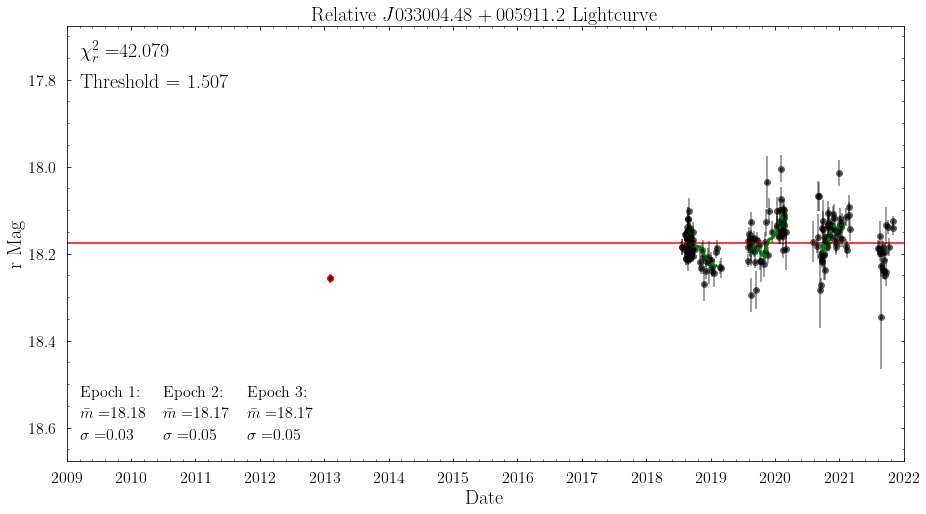

In [22]:
TAP_service = vo.dal.TAPService("http://vao.stsci.edu/PS1DR2/tapservice.aspx")

data_master(['J033004.48+005911.2'], agn_ras, agn_decs, '/Volumes/BackUp/ztf_data/agn_data/', '/Users/ecochran/caltech/agn/data/qso_data/')

In [5]:
def data_test(agn):
    test_table = fits.open('/Volumes/BackUp/ztf_data/agn_data/' + agn + '/data_' + agn + '.fits')
    test_data = test_table[1].data

    cal_table = fits.open('/Users/ecochran/caltech/agn/data/qso_data/'+ agn +'/cal_table.fits')
    cal_data = cal_table[1].data

    ##Need to load in QSO information to plug in RA and DEC

    agn_table = fits.open('/Users/ecochran/caltech/agn/data/variable_list/Abhi_paper2_WISE_MIRvariable.fits')

    agn_table_data = agn_table[1].data    
    
    
    mags = test_data['QSO_MAGS']
    mag_errs = test_data['QSO_MAG_ERR']
    fluxes = test_data['QSO_FLUXES']
    flux_errs = test_data['QSO_FLUX_ERR']
    epochs = test_data['EPOCHS']
    qso_name = agn
    cal_ra = cal_data['CAL_RA']
    cal_dec = cal_data['CAL_DEC']
    cal_mag = cal_data['CAL_MAG']
    qso_ra = agn_table_data['WISE_RA'][np.where(agn_table_data['WISE_DESIGNATION'] == qso_name)]
    qso_dec = agn_table_data['WISE_Dec'][np.where(agn_table_data['WISE_DESIGNATION'] == qso_name)]
    
    return(mags, mag_errs, fluxes, flux_errs, epochs, qso_name, cal_ra, cal_dec, cal_mag, qso_ra, qso_dec)

In [23]:
agn_mags = {}
agn_mag_errs = {}
agn_fluxes = {}
agn_flux_errs = {}
agn_epochs = {}
agn_ra = {}
agn_dec = {}

for agn in os.listdir('/Volumes/BackUp/ztf_data/agn_data/'):
    if agn.startswith('J'):
        mags, mag_errs, fluxes, flux_errs, epochs, qso_name, cal_ra, cal_dec, cal_mag,qso_ra, qso_dec = data_test(agn)

        agn_mags[agn] = mags
        agn_mag_errs[agn] = mag_errs
        agn_fluxes[agn] = fluxes
        agn_flux_errs[agn] = flux_errs
        agn_epochs[agn] = epochs
        agn_ra[agn] = qso_ra
        agn_dec[agn] = qso_dec

In [16]:
zquery = query.ZTFQuery()

zquery.load_metadata(radec=[agn_ra['J000911.60-003654.7'][0], agn_dec['J000911.60-003654.7'][0]], sql_query="filtercode = 'zr' AND infobits < 10")

urls = zquery.get_data_path(suffix='sciimg.fits')

In [18]:
exposure = fits.open('https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0926/279363/ztf_20200926279363_000396_zr_c14_o_q3_sciimg.fits')

exposure_data = exposure[0].data

In [21]:
exposure[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 3072                                                  
NAXIS2  =                 3080                                                  
BUNIT   = 'Data Value'                                                          
ORIGIN  = 'Zwicky Transient Facility' / Data origin                             
OBSERVER= 'ZTF Robotic Observing Software' / Observer                           
ROBOSOFT= '0.99.28  Sep 14, 2020' / Robotic software version                    
FITSSOFT= '0.99.28  Sep 14, 2020' / FITS software version                       
INSTRUME= 'ZTF/MOSAIC'         / Instrument name                                
DETECTOR= '        '           / Detector controller                            
DETSOFT = '        '        